In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
#plt.style.use('fivethirtyeight')

# 使用finlab API
https://ai.finlab.tw/database/

# 目的 ： 透過機器學股票預測, 來做某檔股票進出場的建議. 
    * 假設情境是每兩個的做一次進出場決策.
    1. 預測標的 : 2個禮拜後的平均股價 (透過機器學習找到最適合的區段)

        目前結論 : 
            1. 相比 Time-Series 使用 K-Fold 的方式去訓練可以達到比較好的預測力.
            2. 其他股票 例如 台積電 無法使用此方法預測

    

* 研究遠傳 ( 4904 )股票
    * 基本 Time-Series EDA
    * 製作變數
        * 遠傳本身
            * moving_avg 
    * 股價預測模型
        * Time-Series Split 
        * K-Fold Split
    
    * 找 Correlation 高的股票
        * 增加 Correlation 高的股票的變數


In [2]:
close = pd.read_pickle('/Users/kevintsai/Google Drive/My Drive/finlab_db/price#收盤價.pickle')
volume = pd.read_pickle('/Users/kevintsai/Google Drive/My Drive/finlab_db/price#成交股數.pickle')
transaction = pd.read_pickle('/Users/kevintsai/Google Drive/My Drive/finlab_db/price#成交筆數.pickle')
price = pd.read_pickle('/Users/kevintsai/Google Drive/My Drive/finlab_db/price#成交金額.pickle')

In [3]:
close.head(5)

symbol,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2007-04-23,9.54,57.85,32.83,38.40,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,30.35,9.78,73.6,13.25,51.3,72.4,NaN,46.0,49.6
2007-04-24,9.54,58.10,32.99,38.65,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,30.50,9.91,75.0,13.25,50.5,71.6,NaN,45.9,50.4
2007-04-25,9.52,57.60,32.80,38.59,NaN,NaN,NaN,NaN,NaN,NaN,...,32.3,29.50,10.10,74.6,13.30,49.9,71.6,NaN,49.1,49.1
2007-04-26,9.59,57.70,32.80,38.60,NaN,NaN,NaN,NaN,NaN,NaN,...,31.6,29.15,10.80,74.5,13.25,49.5,71.0,NaN,48.9,48.0
2007-04-27,9.55,57.50,32.72,38.40,NaN,NaN,NaN,NaN,NaN,NaN,...,31.4,28.50,11.55,75.7,13.15,48.8,69.5,NaN,48.6,46.5


In [4]:
volume.head(5)

symbol,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2007-04-23,104000.0,8571000.0,779000.0,104000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,721146.0,25049679.0,35957.0,464653.0,8000.0,355794.0,1163530.0,NaN,413406.0,751560.0
2007-04-24,187000.0,2483010.0,287100.0,221000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1805000.0,15306352.0,52090.0,286392.0,9000.0,140200.0,925687.0,NaN,271693.0,1566560.0
2007-04-25,90000.0,1232000.0,138000.0,194000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2262711.0,9530053.0,57403.0,183000.0,16000.0,269570.0,847400.0,NaN,365100.0,983002.0
2007-04-26,102000.0,6357000.0,110001.0,137001.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1114521.0,7677908.0,326998.0,306539.0,14000.0,131000.0,567750.0,NaN,254348.0,1754381.0
2007-04-27,26000.0,1070000.0,100000.0,146229.0,NaN,NaN,NaN,NaN,NaN,NaN,...,813050.0,15485927.0,482872.0,174175.0,24000.0,125000.0,685194.0,NaN,75900.0,1776000.0


In [5]:
# 遠傳 : 4904
# 中華電 : 2412
# 台灣大 : 3045
# 台積電 : 2330
target = '4904'
days_pred = 15


df_close = pd.DataFrame(close[[target,'0050']]).copy()
df_close.columns = [target+'_close', '0050_close']

df_volume = pd.DataFrame(volume[[target,'0050']]).copy()
df_volume.columns = [target+'_volume', '0050_volume']

df_transaction = pd.DataFrame(close[[target,'0050']]).copy()
df_transaction.columns = [target+'_transaction', '0050_transaction']

df_price = pd.DataFrame(close[[target,'0050']]).copy()
df_price.columns = [target+'_price', '0050_price']

# Visualise Data

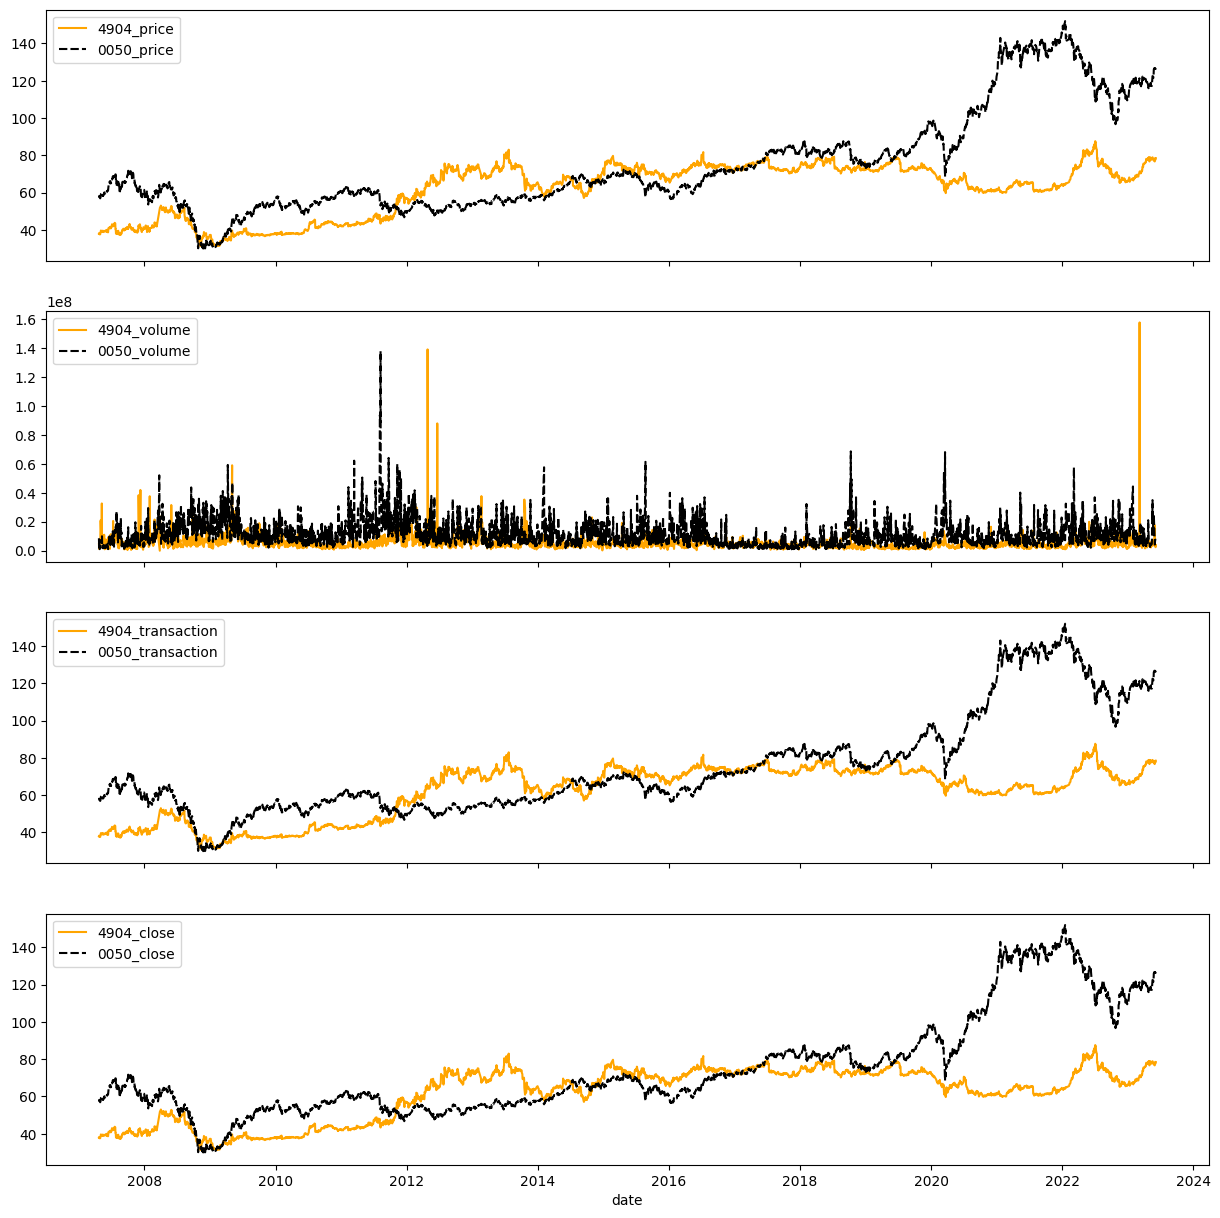

In [6]:
fig, axs = plt.subplots(4,1
                        , figsize=(15,15)
                        ,sharex=True)


sns.lineplot(ax = axs[3]
             , data = df_close
             , palette=['orange','black']
             #, ls = ['','--' ]
             )

sns.lineplot(ax = axs[2]
             ,data = df_transaction
             , palette=['orange','black']
             #, ls = ['','--' ]
             )


sns.lineplot( ax = axs[1]
             , data = df_volume
             , palette=['orange','black']
             #, ls = ['','--' ]
             )


sns.lineplot(ax = axs[0]
             , data = df_price
             , palette=['orange','black']
             #, ls = ['','--' ]
             )


plt.show()

In [7]:
#Post 2014 is more stable 
#df = df.loc[df.index >= '2014-01-01'].copy()

In [8]:
def add_date_features(df):
    df = df.copy()

    df['feature_dayofweek'] = df.index.day_of_week
    df['feature_day'] = df.index.day
    df['feature_quarter'] = df.index.quarter
    df['feature_month'] = df.index.month
    df['feature_year'] = df.index.year
    df['feature_dayofyear'] = df.index.dayofyear

    return df

In [9]:
df_close = add_date_features(df_close)

Text(0.5, 1.0, '4904 by Month')

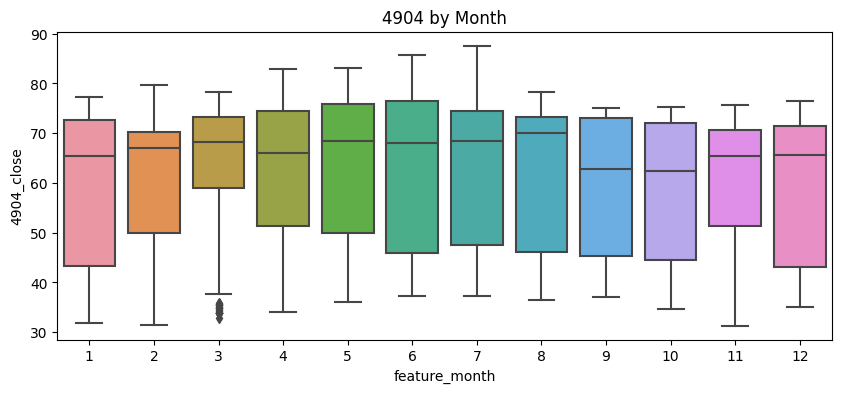

In [10]:
# check for seasonallity

fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=df_close
            , x='feature_month'
            , y=target + '_close'
            )

ax.set_title(target + ' by Month')

# Feature Creation
    * moving average
    * slope 

In [11]:
def add_close_feature (close_df, target):
    close_df = close_df.copy()

    # moving average
    close_df[target + '_feature_close_avg_5_days'] = close_df[target + '_close'].rolling(5).mean()
    close_df[target + '_feature_close_avg_10_days'] = close_df[target + '_close'].rolling(10).mean()
    close_df[target + '_feature_close_avg_20_days'] = close_df[target + '_close'].rolling(20).mean()
    close_df[target + '_feature_close_avg_30_days'] = close_df[target + '_close'].rolling(30).mean()

    # slope
    close_df[target + '_feature_close_avg_slope_5_10_days'] = (close_df[target + '_feature_close_avg_5_days'] / close_df[target + '_feature_close_avg_10_days']).round(5)
    close_df[target + '_feature_close_avg_slope_5_20_days'] = (close_df[target + '_feature_close_avg_5_days'] / close_df[target + '_feature_close_avg_20_days']).round(5)
    close_df[target + '_feature_close_avg_slope_5_30_days'] = (close_df[target + '_feature_close_avg_5_days'] / close_df[target + '_feature_close_avg_30_days']).round(5)
    
    close_df[target + '_feature_close_avg_slope_10_20_days'] = (close_df[target + '_feature_close_avg_10_days'] / close_df[target + '_feature_close_avg_20_days']).round(5)
    close_df[target + '_feature_close_avg_slope_10_30_days'] = (close_df[target + '_feature_close_avg_10_days'] / close_df[target + '_feature_close_avg_30_days']).round(5)

    close_df[target + '_feature_close_avg_slope_20_30_days'] = (close_df[target + '_feature_close_avg_20_days'] / close_df[target + '_feature_close_avg_30_days']).round(5)

    return close_df  

def add_volume_feature (volume_df, target):
    volume_df = volume_df.copy()

    # moving average
    volume_df[target + '_feature_volume_avg_5_days'] = volume_df[target + '_volume'].rolling(5).mean()
    volume_df[target + '_feature_volume_avg_10_days'] = volume_df[target + '_volume'].rolling(10).mean()
    volume_df[target + '_feature_volume_avg_20_days'] = volume_df[target + '_volume'].rolling(20).mean()
    volume_df[target + '_feature_volume_avg_30_days'] = volume_df[target + '_volume'].rolling(30).mean()

    # slope
    volume_df[target + '_feature_volume_avg_slope_5_10_days'] = (volume_df[target + '_feature_volume_avg_5_days'] / volume_df[target + '_feature_volume_avg_10_days']).round(5)
    volume_df[target + '_feature_volume_avg_slope_5_20_days'] = (volume_df[target + '_feature_volume_avg_5_days'] / volume_df[target + '_feature_volume_avg_20_days']).round(5)
    volume_df[target + '_feature_volume_avg_slope_5_30_days'] = (volume_df[target + '_feature_volume_avg_5_days'] / volume_df[target + '_feature_volume_avg_30_days']).round(5)
    
    volume_df[target + '_feature_volume_avg_slope_10_20_days'] = (volume_df[target + '_feature_volume_avg_10_days'] / volume_df[target + '_feature_volume_avg_20_days']).round(5)
    volume_df[target + '_feature_volume_avg_slope_10_30_days'] = (volume_df[target + '_feature_volume_avg_10_days'] / volume_df[target + '_feature_volume_avg_30_days']).round(5)

    volume_df[target + '_feature_volume_avg_slope_20_30_days'] = (volume_df[target + '_feature_volume_avg_20_days'] / volume_df[target + '_feature_volume_avg_30_days']).round(5)

    return volume_df  

def add_transaction_feature (transaction_df, target):
    transaction_df = transaction_df.copy()

    # moving average
    transaction_df[target + '_feature_transaction_avg_5_days'] = transaction_df[target + '_transaction'].rolling(5).mean()
    transaction_df[target + '_feature_transaction_avg_10_days'] = transaction_df[target + '_transaction'].rolling(10).mean()
    transaction_df[target + '_feature_transaction_avg_20_days'] = transaction_df[target + '_transaction'].rolling(20).mean()
    transaction_df[target + '_feature_transaction_avg_30_days'] = transaction_df[target + '_transaction'].rolling(30).mean()

    # slope
    transaction_df[target + '_feature_transaction_avg_slope_5_10_days'] = (transaction_df[target + '_feature_transaction_avg_5_days'] / transaction_df[target + '_feature_transaction_avg_10_days']).round(5)
    transaction_df[target + '_feature_transaction_avg_slope_5_20_days'] = (transaction_df[target + '_feature_transaction_avg_5_days'] / transaction_df[target + '_feature_transaction_avg_20_days']).round(5)
    transaction_df[target + '_feature_transaction_avg_slope_5_30_days'] = (transaction_df[target + '_feature_transaction_avg_5_days'] / transaction_df[target + '_feature_transaction_avg_30_days']).round(5)
    
    transaction_df[target + '_feature_transaction_avg_slope_10_20_days'] = (transaction_df[target + '_feature_transaction_avg_10_days'] / transaction_df[target + '_feature_transaction_avg_20_days']).round(5)
    transaction_df[target + '_feature_transaction_avg_slope_10_30_days'] = (transaction_df[target + '_feature_transaction_avg_10_days'] / transaction_df[target + '_feature_transaction_avg_30_days']).round(5)

    transaction_df[target + '_feature_transaction_avg_slope_20_30_days'] = (transaction_df[target + '_feature_transaction_avg_20_days'] / transaction_df[target + '_feature_transaction_avg_30_days']).round(5)

    return transaction_df  

def add_price_feature (price_df, target):
    price_df = price_df.copy()

    # moving average
    price_df[target + '_feature_price_avg_5_days'] = price_df[target + '_price'].rolling(5).mean()
    price_df[target + '_feature_price_avg_10_days'] = price_df[target + '_price'].rolling(10).mean()
    price_df[target + '_feature_price_avg_20_days'] = price_df[target + '_price'].rolling(20).mean()
    price_df[target + '_feature_price_avg_30_days'] = price_df[target + '_price'].rolling(30).mean()

    # slope
    price_df[target + '_feature_price_avg_slope_5_10_days'] = (price_df[target + '_feature_price_avg_5_days'] / price_df[target + '_feature_price_avg_10_days']).round(5)
    price_df[target + '_feature_price_avg_slope_5_20_days'] = (price_df[target + '_feature_price_avg_5_days'] / price_df[target + '_feature_price_avg_20_days']).round(5)
    price_df[target + '_feature_price_avg_slope_5_30_days'] = (price_df[target + '_feature_price_avg_5_days'] / price_df[target + '_feature_price_avg_30_days']).round(5)
    
    price_df[target + '_feature_price_avg_slope_10_20_days'] = (price_df[target + '_feature_price_avg_10_days'] / price_df[target + '_feature_price_avg_20_days']).round(5)
    price_df[target + '_feature_price_avg_slope_10_30_days'] = (price_df[target + '_feature_price_avg_10_days'] / price_df[target + '_feature_price_avg_30_days']).round(5)

    price_df[target + '_feature_price_avg_slope_20_30_days'] = (price_df[target + '_feature_price_avg_20_days'] / price_df[target + '_feature_price_avg_30_days']).round(5)

    return price_df  




In [12]:
# create predictoin target == 10 day rolling avg in 2wks time 

model_close_data  = add_close_feature(df_close.sort_index(), target)
model_volume_data  = add_volume_feature(df_volume.sort_index(), target)
model_transaction_data  = add_transaction_feature(df_transaction.sort_index(), target)
model_price_data  = add_price_feature(df_price.sort_index(), target)

model_close_data = model_close_data.sort_index()

 
model_close_data[target + '_y'] = model_close_data.shift(-1*days_pred)[target + '_feature_close_avg_5_days']

model_data = (model_close_data
              .join(model_volume_data)
              .join(model_transaction_data)
              .join(model_price_data)
              )

In [13]:
#(model_close_data.loc['2022-01-01':'2022-03-01', ['2330_close', '2330_feature_close_avg_5_days', '2330_y']]).to_clipboard()

In [14]:
model_data.tail(5).transpose()

date,2023-05-31,2023-06-01,2023-06-02,2023-06-05,2023-06-06
4904_close,7.670000e+01,7.830000e+01,7.810000e+01,7.770000e+01,7.850000e+01
0050_close,1.261500e+02,1.251500e+02,1.267500e+02,1.263500e+02,1.267000e+02
feature_dayofweek,2.000000e+00,3.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00
feature_day,3.100000e+01,1.000000e+00,2.000000e+00,5.000000e+00,6.000000e+00
feature_quarter,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
feature_month,5.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
feature_year,2.023000e+03,2.023000e+03,2.023000e+03,2.023000e+03,2.023000e+03
feature_dayofyear,1.510000e+02,1.520000e+02,1.530000e+02,1.560000e+02,1.570000e+02
4904_feature_close_avg_5_days,7.732000e+01,7.744000e+01,7.746000e+01,7.758000e+01,7.786000e+01
4904_feature_close_avg_10_days,7.781000e+01,7.776000e+01,7.768000e+01,7.762000e+01,7.769000e+01


# Model Training

## Define Training and validation

In [15]:

# split data into training and testing

train_data = model_data.query('feature_year > 2012 and feature_year <= 2021').copy()
test_data = model_data.query('feature_year >= 2022').copy()


In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, 
                      test_size=365, 
                      gap=1)

X_labels = [x for x in train_data.columns if 'feature_' in x]

y_labels = target + '_y'

fold = 0
preds = []
scores = []
val_result = []
for train_idx, val_idx in tss.split(train_data):
       print(f'Training fold : {fold}')
       
       train = train_data.iloc[train_idx]
       val = train_data.iloc[val_idx]

       X_train = train[X_labels]
       y_train = train[y_labels]

       X_val = val[X_labels]
       y_val = val[y_labels]

       reg = xgb.XGBRegressor(n_estimators = 1000
                              , learning_rate = 0.01
                              , early_stopping_rounds = 50
                              )

       reg.fit(X_train, y_train
               , eval_set = [(X_train,y_train),(X_val, y_val)]
               , verbose = 0
               )
       
       y_pred = reg.predict(X_val)
       preds.append(y_pred)
       score = np.sqrt(mean_squared_error(y_val, y_pred))
       scores.append(score)
       val_result.append(reg.evals_result())
       fold +=1


Training fold : 0
Training fold : 1
Training fold : 2
Training fold : 3
Training fold : 4


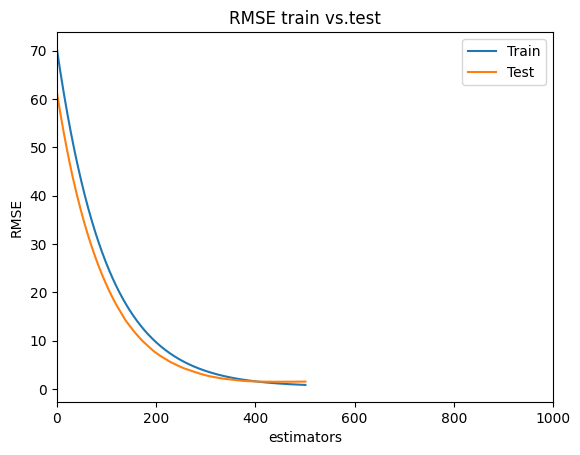

In [17]:
result = reg.evals_result()

train_rmse = result['validation_0']['rmse']
val_rmse = result['validation_1']['rmse']
estimator = range(0, len(result['validation_1']['rmse']))
fig, ax = plt.subplots()

ax.plot(estimator, train_rmse)
ax.plot(estimator, val_rmse)
ax.set_xlabel('estimators')
ax.set_ylabel('RMSE')
ax.set_title('RMSE train vs.test')

ax.set_xlim(left=0, right=1000)
ax.legend(['Train', 'Test'])

plt.show()

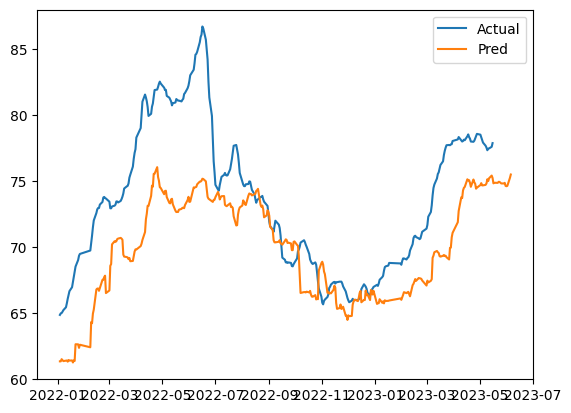

In [18]:
# Predict

reg = xgb.XGBRegressor(n_estimators = 600
                            , learning_rate = 0.01
                            #, early_stopping_rounds = 50
                            )

reg.fit(X_train, y_train)


pred_test = reg.predict(test_data[X_labels])
y_test = test_data[y_labels]


figs, ax = plt.subplots()

ax.plot(test_data.index, y_test)
ax.plot(test_data.index, pred_test)

ax.legend(['Actual', 'Pred'])

plt.show()

#score = np.sqrt(mean_squared_error(pred_test, y_test))
      
#print(f'RMSE : {score:2f}')

In [19]:
test_data.tail(30)[[target + '_close', target +'_y', target +'_feature_close_avg_5_days']].to_clipboard()

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

kf = KFold(n_splits=5
        #, random_state= 10
        , shuffle=True
        )


X_labels = [x for x in train_data.columns if 'feature_' in x]

y_labels = target + '_y'

fold = 0
preds = []
scores = []

for train_idx, val_idx in kf.split(train_data):
       print(f'Training fold : {fold}')
       
       train = train_data.iloc[train_idx]
       val = train_data.iloc[val_idx]

       X_train = train[X_labels]
       y_train = train[y_labels]

       X_val = val[X_labels]
       y_val = val[y_labels]

       print(f'Training size : {len(X_train)}')
       print(f'Val size : {len(X_val)}')
        
       reg = xgb.XGBRegressor(n_estimators = 1000
                              , early_stopping_rounds = 10
                              , learning_rate = 0.01
                              )

       reg.fit(X_train, y_train
               , eval_set = [(X_train,y_train),(X_val, y_val)]
               , verbose =0
               )
       
       y_pred = reg.predict(X_val)
       preds.append(y_pred)
       score = np.sqrt(mean_squared_error(y_val, y_pred))
       scores.append(score)
       fold +=1


Training fold : 0
Training size : 1764
Val size : 442
Training fold : 1
Training size : 1765
Val size : 441
Training fold : 2
Training size : 1765
Val size : 441
Training fold : 3
Training size : 1765
Val size : 441
Training fold : 4
Training size : 1765
Val size : 441


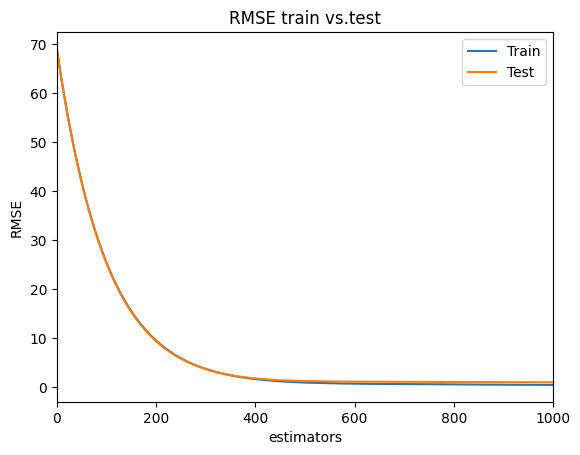

In [21]:
result = reg.evals_result()

train_rmse = result['validation_0']['rmse']
val_rmse = result['validation_1']['rmse']
estimator = range(0, len(result['validation_1']['rmse']))
fig, ax = plt.subplots()

ax.plot(estimator, train_rmse)
ax.plot(estimator, val_rmse)
ax.set_xlabel('estimators')
ax.set_ylabel('RMSE')
ax.set_title('RMSE train vs.test')

ax.set_xlim(left=0, right=1000)
ax.legend(['Train', 'Test'])

plt.show()

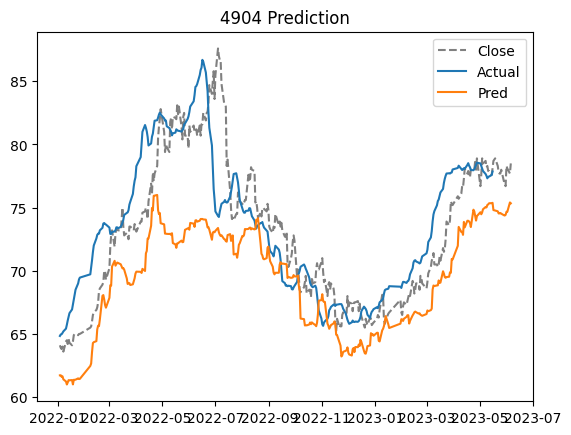

In [22]:
# Predict
reg = xgb.XGBRegressor(n_estimators = 600
                            , learning_rate = 0.01
                            #, early_stopping_rounds = 50
                            )

reg.fit(X_train, y_train)


pred_test = reg.predict(test_data[X_labels])
y_test = test_data[y_labels]


figs, ax = plt.subplots()

ax.plot(test_data.index, test_data[target + '_close'], color = 'grey', linestyle = '--')
ax.plot(test_data.index, y_test)
ax.plot(test_data.index, pred_test)

ax.legend(['Close', 'Actual', 'Pred'])
ax.set_title(target + ' Prediction')
plt.show()

#score = np.sqrt(mean_squared_error(pred_test, y_test))
       
#print(f'RMSE : {score:2f}')

In [23]:
import datetime

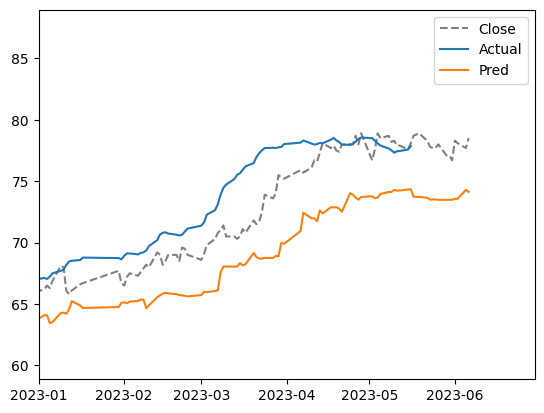

In [24]:
# Predict
reg = xgb.XGBRegressor(n_estimators = 400
                            , learning_rate = 0.01
                            #, early_stopping_rounds = 50
                            )

reg.fit(X_train, y_train)


pred_test = reg.predict(test_data[X_labels])
y_test = test_data[y_labels]


figs, ax = plt.subplots()

ax.plot(test_data.index, test_data[target + '_close'], color = 'grey', linestyle = '--')
ax.plot(test_data.index, y_test)
ax.plot(test_data.index, pred_test)

ax.set_xlim(datetime.date(2023,1,1),datetime.date(2023,6,30))
ax.legend(['Close', 'Actual', 'Pred'])

plt.show()

In [25]:

'''
# get target stock trading count
target_cnt = close[target].count()

# get stock list with at least 90% of target trading count for a fair corr comparison
cmp_target_list = (close.count() > (target_cnt * 0.9)).index

# create dataset for computing corr
corr_df = close[cmp_target_list].copy()

# computing corr matrix
corr = corr_df.corr()

high_postive_corr_stocks = (
    corr[target].sort_values()   # sort by corr score, asceding = true
    .index  # stock list 
    [-3:-1]  # ignore target
)

high_negative_corr_stocks = (
    corr[target].sort_values()   # sort by corr score, asceding = true
    .index  # stock list 
    [0:2] 
)
'''

'\n# get target stock trading count\ntarget_cnt = close[target].count()\n\n# get stock list with at least 90% of target trading count for a fair corr comparison\ncmp_target_list = (close.count() > (target_cnt * 0.9)).index\n\n# create dataset for computing corr\ncorr_df = close[cmp_target_list].copy()\n\n# computing corr matrix\ncorr = corr_df.corr()\n\nhigh_postive_corr_stocks = (\n    corr[target].sort_values()   # sort by corr score, asceding = true\n    .index  # stock list \n    [-3:-1]  # ignore target\n)\n\nhigh_negative_corr_stocks = (\n    corr[target].sort_values()   # sort by corr score, asceding = true\n    .index  # stock list \n    [0:2] \n)\n'

<Axes: title={'center': 'Feature Importance'}>

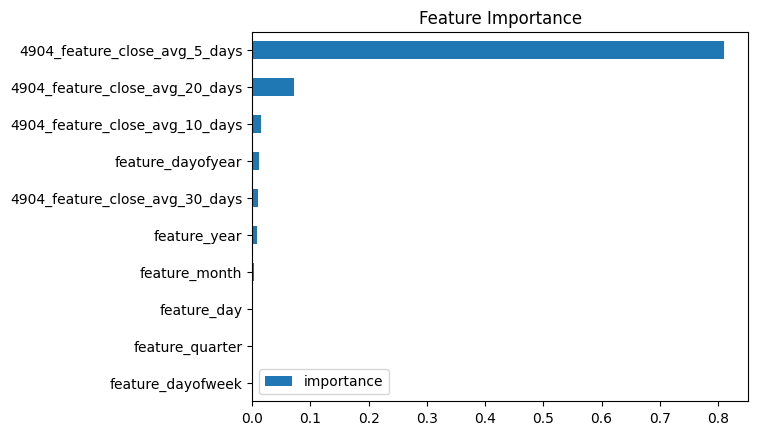

In [26]:
#reg.feature_importances_

fi = pd.DataFrame(data=reg.feature_importances_[:10],
                  index=reg.feature_names_in_[:10],
                  columns = ['importance']
                  )

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')